In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from google.colab import files

In [ ]:
# 1. Veri setini Colab'a yükleme
uploaded = files.upload()  # Bu komut Colab'da bir dosya yükleme penceresi açar
df = pd.read_csv(list(uploaded.keys())[0])  # Yüklenen CSV dosyasını oku


Saving Steel_industry_data.csv to Steel_industry_data.csv


In [ ]:
df.head(5)

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
0,01/01/2018 00:15,3.17,2.95,0.0,0.0,73.21,100.0,900,Weekday,Monday,Light_Load
1,01/01/2018 00:30,4.00,4.46,0.0,0.0,66.77,100.0,1800,Weekday,Monday,Light_Load
2,01/01/2018 00:45,3.24,3.28,0.0,0.0,70.28,100.0,2700,Weekday,Monday,Light_Load
3,01/01/2018 01:00,3.31,3.56,0.0,0.0,68.09,100.0,3600,Weekday,Monday,Light_Load
4,01/01/2018 01:15,3.82,4.50,0.0,0.0,64.72,100.0,4500,Weekday,Monday,Light_Load


In [ ]:

# 2. Tarih-saat sütununu datetime formatına çevirme
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y %H:%M')
df = df.sort_values('date')  # Tarihe göre sıralama

In [ ]:

# 3. Gerekli sütunları seçme ve ek özellikler çıkarma
df['hour'] = df['date'].dt.hour
df['day'] = df['date'].dt.dayofweek  # 0: Pazartesi, 6: Pazar
features = ['Usage_kWh', 'hour', 'day']  # Tahmin için kullanacağımız özellikler
data = df[features]

In [ ]:
df.head(5)

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type,hour,day
95,2018-01-01 00:00:00,3.42,3.46,0.0,0.0,70.30,100.0,0,Weekday,Monday,Light_Load,0,0
0,2018-01-01 00:15:00,3.17,2.95,0.0,0.0,73.21,100.0,900,Weekday,Monday,Light_Load,0,0
1,2018-01-01 00:30:00,4.00,4.46,0.0,0.0,66.77,100.0,1800,Weekday,Monday,Light_Load,0,0
2,2018-01-01 00:45:00,3.24,3.28,0.0,0.0,70.28,100.0,2700,Weekday,Monday,Light_Load,0,0
3,2018-01-01 01:00:00,3.31,3.56,0.0,0.0,68.09,100.0,3600,Weekday,Monday,Light_Load,1,0


In [ ]:

# 4. Veriyi normalizasyon (0-1 aralığına ölçeklendirme)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)


In [ ]:
# 5. Zaman serisi penceresi oluşturma fonksiyonu
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])  # Geçmiş seq_length kadar veri
        y.append(data[i + seq_length, 0])  # Bir sonraki Usage_kWh değeri
    return np.array(X), np.array(y)

# Parametreler
sequence_length = 96  # 24 saatlik veri (15 dakikada 1 ölçüm, 24*4=96)
X, y = create_sequences(scaled_data, sequence_length)

In [ ]:
data.head(5)

,Usage_kWh,hour,day
95,3.42,0,0
0,3.17,0,0
1,4.00,0,0
2,3.24,0,0
3,3.31,1,0


In [ ]:
scaled_data[:5]

array([[0.02175849, 0.        , 0.        ],
       [0.02016796, 0.        , 0.        ],
       [0.02544853, 0.        , 0.        ],
       [0.02061331, 0.        , 0.        ],
       [0.02105866, 0.04347826, 0.        ]])

In [ ]:
# 6. Eğitim ve test setine ayırma
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [ ]:
# 7. LSTM modelini oluşturma
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(sequence_length, len(features)), return_sequences=True))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))  # Tek bir çıktı (Usage_kWh tahmini)
model.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# 8. Modeli eğitme
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=1)


Epoch 1/20
787/787 ━━━━━━━━━━━━━━━━━━━━ 84s 101ms/step - loss: 0.0187 - val_loss: 0.0061
Epoch 2/20
787/787 ━━━━━━━━━━━━━━━━━━━━ 78s 96ms/step - loss: 0.0082 - val_loss: 0.0055
Epoch 3/20
787/787 ━━━━━━━━━━━━━━━━━━━━ 83s 97ms/step - loss: 0.0068 - val_loss: 0.0047
Epoch 4/20
787/787 ━━━━━━━━━━━━━━━━━━━━ 75s 96ms/step - loss: 0.0068 - val_loss: 0.0050
Epoch 5/20
787/787 ━━━━━━━━━━━━━━━━━━━━ 85s 100ms/step - loss: 0.0069 - val_loss: 0.0043
Epoch 6/20
787/787 ━━━━━━━━━━━━━━━━━━━━ 81s 98ms/step - loss: 0.0061 - val_loss: 0.0042
Epoch 7/20
787/787 ━━━━━━━━━━━━━━━━━━━━ 77s 97ms/step - loss: 0.0059 - val_loss: 0.0041
Epoch 8/20
787/787 ━━━━━━━━━━━━━━━━━━━━ 78s 99ms/step - loss: 0.0057 - val_loss: 0.0041
Epoch 9/20
787/787 ━━━━━━━━━━━━━━━━━━━━ 79s 100ms/step - loss: 0.0058 - val_loss: 0.0038
Epoch 10/20
787/787 ━━━━━━━━━━━━━━━━━━━━ 80s 97ms/step - loss: 0.0057 - val_loss: 0.0038
Epoch 11/20
787/787 ━━━━━━━━━━━━━━━━━━━━ 83s 98ms/step - loss: 0.0054 - val_loss: 0.0039
Epoch 12/20
787/787 ━━━━━━━

In [ ]:

# 9. Tahmin yapma
y_pred = model.predict(X_test)

219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step


In [ ]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test_original, y_pred_original)
print(f"R² Skoru: {r2:.4f}")


R² Skoru: 0.9109


In [ ]:
# 10. Normalizasyonu geri alma (sadece Usage_kWh için)
y_test_reshaped = np.zeros((len(y_test), len(features)))
y_test_reshaped[:, 0] = y_test
y_pred_reshaped = np.zeros((len(y_pred), len(features)))
y_pred_reshaped[:, 0] = y_pred.flatten()

y_test_original = scaler.inverse_transform(y_test_reshaped)[:, 0]
y_pred_original = scaler.inverse_transform(y_pred_reshaped)[:, 0]


In [ ]:
# 11. Model değerlendirme
mse = mean_squared_error(y_test_original, y_pred_original)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 87.7873647647538


In [ ]:
# 12. Saatlik tahminler için veriyi gruplama
hourly_df = df.groupby([df['date'].dt.date, 'hour'])['Usage_kWh'].mean().reset_index()
hourly_actual = hourly_df.tail(24)['Usage_kWh'].values  # Son 24 saatlik gerçek veri


In [ ]:
# 13. 24 saatlik tahmin (son pencereyi kullanarak)
last_sequence = scaled_data[-sequence_length:].reshape(1, sequence_length, len(features))
next_96_pred = []
for _ in range(96):  # 24 saatlik tahmin (96 adet 15 dakikalık tahmin)
    pred = model.predict(last_sequence)[0, 0]
    next_96_pred.append(pred)
    # Yeni tahmini ekleyip pencereyi kaydıralım
    new_row = last_sequence[0, -1].copy()
    new_row[0] = pred  # Usage_kWh tahmini
    new_row[1] = (new_row[1] + 0.25) % 24  # Saat güncellemesi (15 dk ekleme)
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1] = new_row

# Normalizasyonu geri alma
next_96_pred_reshaped = np.zeros((len(next_96_pred), len(features)))
next_96_pred_reshaped[:, 0] = next_96_pred
next_96_pred_original = scaler.inverse_transform(next_96_pred_reshaped)[:, 0]

# Saatlik ortalamaları hesaplama
hourly_pred = [next_96_pred_original[i:i+4].mean() for i in range(0, 96, 4)]
print(f"24 Saatlik Toplam Tahmin: {sum(hourly_pred):.2f} kWh")
print("Saatlik Tahminler:")
for hour, pred in enumerate(hourly_pred):
    print(f"Saat {hour:02d}:00 - {pred:.2f} kWh")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━

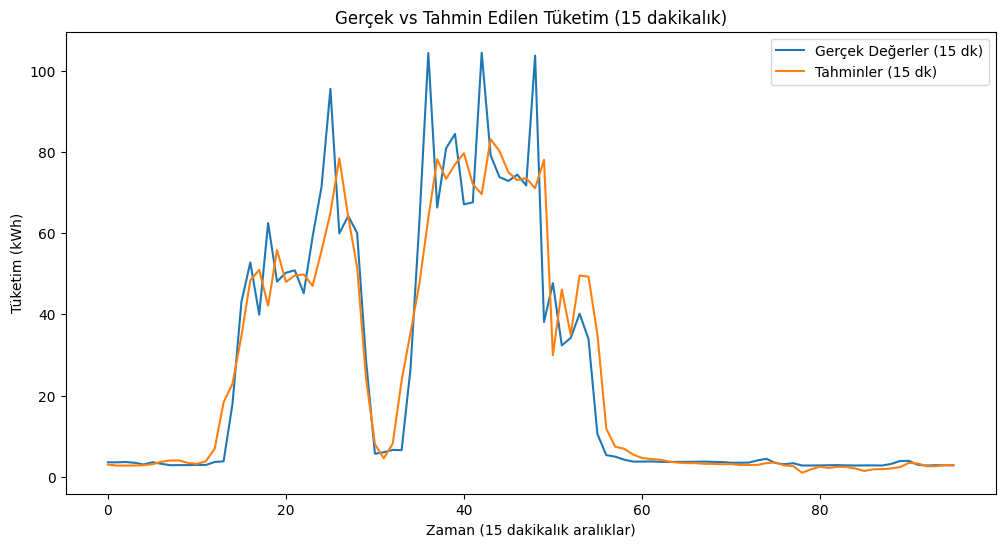

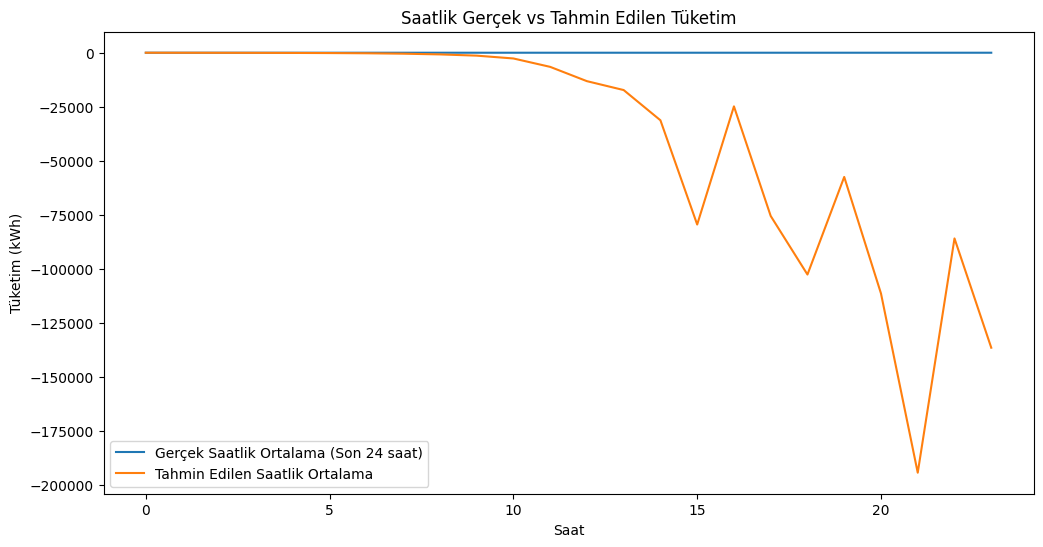

In [ ]:
# 14. Görselleştirme
plt.figure(figsize=(12, 6))
plt.plot(y_test_original[:96], label='Gerçek Değerler (15 dk)')
plt.plot(y_pred_original[:96], label='Tahminler (15 dk)')
plt.xlabel('Zaman (15 dakikalık aralıklar)')
plt.ylabel('Tüketim (kWh)')
plt.title('Gerçek vs Tahmin Edilen Tüketim (15 dakikalık)')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(range(24), hourly_actual, label='Gerçek Saatlik Ortalama (Son 24 saat)')
plt.plot(range(24), hourly_pred, label='Tahmin Edilen Saatlik Ortalama')
plt.xlabel('Saat')
plt.ylabel('Tüketim (kWh)')
plt.title('Saatlik Gerçek vs Tahmin Edilen Tüketim')
plt.legend()
plt.show()

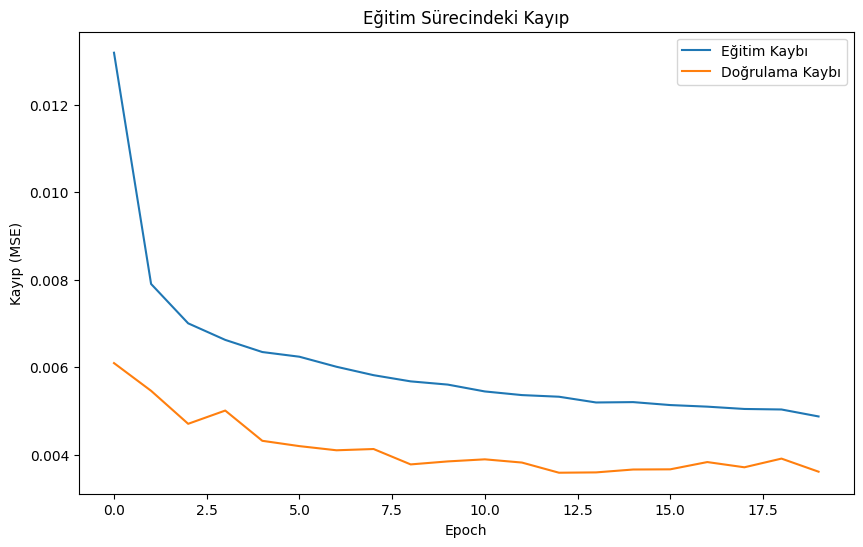

In [ ]:
# 15. Eğitim kaybını görselleştirme
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp (MSE)')
plt.title('Eğitim Sürecindeki Kayıp')
plt.legend()
plt.show()